<a href="https://colab.research.google.com/github/Ankur7470/nlp-assignment2/blob/main/Copy_of_NLP_assgn2_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2048]:
!pip install gensim

## Importing the necessary libraries

In [2049]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset,  WeightedRandomSampler
from gensim.models import Word2Vec
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from collections import Counter


## EDA

### Loading the Sentiment Analysis Dataset

In [2050]:
sentiment_data = pd.read_csv("sentimentdataset.csv")

### Information about the Dataset

In [2051]:
sentiment_data.head(10)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19
5,5,5,Feeling grateful for the little things in lif...,Positive,2023-01-16 09:10:00,GratitudeNow,Twitter,#Gratitude #PositiveVibes,25.0,50.0,India,2023,1,16,9
6,6,6,Rainy days call for cozy blankets and hot coc...,Positive,2023-01-16 14:45:00,RainyDays,Facebook,#RainyDays #Cozy,10.0,20.0,Canada,2023,1,16,14
7,7,7,The new movie release is a must-watch! ...,Positive,2023-01-16 19:30:00,MovieBuff,Instagram,#MovieNight #MustWatch,15.0,30.0,USA,2023,1,16,19
8,8,8,Political discussions heating up on the timel...,Negative,2023-01-17 08:00:00,DebateTalk,Twitter,#Politics #Debate,30.0,60.0,USA,2023,1,17,8
9,9,9,Missing summer vibes and beach days. ...,Neutral,2023-01-17 12:20:00,BeachLover,Facebook,#Summer #BeachDays,18.0,35.0,Australia,2023,1,17,12


In [2052]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [2053]:
sentiment_data = sentiment_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour'])

In [2054]:
sentiment_data = sentiment_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [2055]:
sentiment_data.head(10)

,Text,Sentiment
0,Exploring the world of digital art. It's never...,Curiosity
1,Feeling inspired after attending a workshop. ...,Positive
2,"Eyes wide open in the night, fearful shadows ...",Fearful
3,"A soul weathered by the storm of heartbreak, s...",Heartbreak
4,"Attended a wine tasting event, savoring the ri...",Joy
5,"Despite meticulous training, the swimmer faces...",Miscalculation
6,Excited about the upcoming gaming tournament....,Positive
7,Reflecting on personal growth achieved through...,Reflection
8,Achieving a personal best in a track and field...,Happy
9,Immersed in the pulsating beats of a Bruno Mar...,Joy


### Working with Sentiment Labels

In [2056]:
print("No. of Unique Sentiments :", sentiment_data['Sentiment'].nunique())

No. of Unique Sentiments : 279


In [2057]:
sentiment_data['Sentiment'].unique()

array([' Curiosity ', ' Positive  ', ' Fearful ', ' Heartbreak ', ' Joy ',
       ' Miscalculation ', ' Reflection    ', ' Happy ', ' Sorrow      ',
       ' Anticipation  ', ' Grief           ', ' Hate ', ' Acceptance   ',
       ' Sadness      ', ' Excitement   ', ' Euphoria     ',
       ' Frustration ', ' Creativity   ', ' Spark        ', ' Betrayal ',
       ' Surprise     ', ' Curiosity       ', ' Joy          ', ' Awe ',
       ' Coziness     ', ' Inspiration   ', ' Grateful ', ' Enthusiasm ',
       ' Resilience ', ' Contentment ', ' Celestial Wonder ',
       ' Devastated ', ' Elation       ', ' LostLove ',
       ' Whispers of the Past ', ' Empowerment   ', ' Bittersweet ',
       ' Confusion       ', ' Connection ', ' Serenity ', ' Isolation ',
       ' Zest ', ' Excitement    ', ' Nostalgia     ',
       ' Melancholy      ', ' Serenity        ', ' Proud ',
       ' Fulfillment  ', ' Reverence ', ' Boredom ', ' Solitude ',
       ' Admiration ', ' Kind         ', ' Excitemen

In [2058]:
# Stripping the leading and trailing spaces from each sentiment
sentiment_data['Sentiment'] = [sentiment.strip() for sentiment in sentiment_data['Sentiment']]

In [2059]:
sentiment_data['Sentiment'].unique()

array(['Curiosity', 'Positive', 'Fearful', 'Heartbreak', 'Joy',
       'Miscalculation', 'Reflection', 'Happy', 'Sorrow', 'Anticipation',
       'Grief', 'Hate', 'Acceptance', 'Sadness', 'Excitement', 'Euphoria',
       'Frustration', 'Creativity', 'Spark', 'Betrayal', 'Surprise',
       'Awe', 'Coziness', 'Inspiration', 'Grateful', 'Enthusiasm',
       'Resilience', 'Contentment', 'Celestial Wonder', 'Devastated',
       'Elation', 'LostLove', 'Whispers of the Past', 'Empowerment',
       'Bittersweet', 'Confusion', 'Connection', 'Serenity', 'Isolation',
       'Zest', 'Nostalgia', 'Melancholy', 'Proud', 'Fulfillment',
       'Reverence', 'Boredom', 'Solitude', 'Admiration', 'Kind',
       'Contemplation', 'Fear', 'Arousal', 'Inspired', 'Affection',
       'Captivation', 'Embarrassed', 'Thrill', 'Hopeful', 'Frustrated',
       'Satisfaction', 'EmotionalStorm', 'Playful', 'Regret',
       'InnerJourney', 'Enjoyment', 'Disgust', 'JoyfulReunion',
       'Colorful', 'Elegance', 'Desolatio

In [2060]:
print("\nNo. of Unique Sentiments after stripping :", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments after stripping : 191


In [2061]:
sentiment_counts = sentiment_data['Sentiment'].value_counts()
print("Sentiment Counts:\n")
sentiment_counts[:10]

Sentiment Counts:



,count
Sentiment,
Positive,45
Joy,44
Excitement,37
Contentment,19
Neutral,18
Gratitude,18
Curiosity,16
Serenity,15
Happy,14


### Checking for Duplicate Text Entries

In [2062]:
print("No. of Duplicate Text Entries", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries 25


In [2063]:
duplicate_texts = sentiment_data.groupby('Text').size().reset_index(name='count')

In [2064]:
# Filtering texts that appear more than once
duplicate_texts[duplicate_texts['count'] > 1]

,Text,count
1,"A compassionate rain, tears of empathy fallin...",3
4,"A free spirit soaring on the wings of dreams,...",2
12,"A playful escapade in the carnival of life, c...",3
40,"Bathed in the golden hues of gratefulness, a ...",2
52,Charting a course through the waves of hopefu...,2
59,"Confident strides in the dance of life, a bal...",2
81,"Dismissive gestures, a curtain drawn to shiel...",2
93,"Embraced by the hopeful dawn, a gardener sowi...",3
148,"Floating on clouds of inspiration, an artist ...",2
176,"Hopeful whispers of wind, carrying the promis...",2


### Handling Duplicate Text Entries

In [2065]:
# Keeping the first occurrence of each duplicate
sentiment_data = sentiment_data.drop_duplicates(subset=['Text'], keep='first')

In [2066]:
print("No. of Duplicate Text Entries (keeping only the first occurrence): ", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries (keeping only the first occurrence):  0


In [2067]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       707 non-null    object
 1   Sentiment  707 non-null    object
dtypes: object(2)
memory usage: 16.6+ KB


## Data Preprocessing

### Encoding the sentiment labels

In [2068]:
# le = LabelEncoder()
# sentiment_data['Encoded Sentiment'] = le.fit_transform(sentiment_data['Sentiment'])

### Applying Preprocessing to all the texts

In [2069]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

sentiment_data['Tokenized Text'] = [preprocess_text(text) for text in sentiment_data['Text'].values]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset after Preprocessing/Tokenization of texts

In [2070]:
sentiment_data.head(10)

,Text,Sentiment,Tokenized Text
0,Exploring the world of digital art. It's never...,Curiosity,"[exploring, world, digital, art, never, late, ..."
1,Feeling inspired after attending a workshop. ...,Positive,"[feeling, inspired, attending, workshop]"
2,"Eyes wide open in the night, fearful shadows ...",Fearful,"[eye, wide, open, night, fearful, shadow, danc..."
3,"A soul weathered by the storm of heartbreak, s...",Heartbreak,"[soul, weathered, storm, heartbreak, seeking, ..."
4,"Attended a wine tasting event, savoring the ri...",Joy,"[attended, wine, tasting, event, savoring, ric..."
5,"Despite meticulous training, the swimmer faces...",Miscalculation,"[despite, meticulous, training, swimmer, face,..."
6,Excited about the upcoming gaming tournament....,Positive,"[excited, upcoming, gaming, tournament]"
7,Reflecting on personal growth achieved through...,Reflection,"[reflecting, personal, growth, achieved, life,..."
8,Achieving a personal best in a track and field...,Happy,"[achieving, personal, best, track, field, comp..."
9,Immersed in the pulsating beats of a Bruno Mar...,Joy,"[immersed, pulsating, beat, bruno, mar, concer..."


### Extracting the Relevant Columns

In [2071]:
tokenized_texts = sentiment_data['Tokenized Text'].values
# labels = sentiment_data['Encoded Sentiment'].values

### Word2Vec Training & Text Vectorization

#### Train custom Word2Vec model

In [2072]:
word2vec_model = Word2Vec(
    sentences=tokenized_texts,  # List of tokenized sentences
    vector_size=100,            # Size of the word vectors
    window=5,                   # Maximum distance between the current and predicted word
    min_count=1,                # Ignores words with frequency lower than this
    workers=4,                  # Number of CPU cores
    sg = 1
)

In [2073]:
word2vec_model.save("word2vec.model")

#### Word2Vec vocabulary details

In [2074]:
print("Word2Vec vocabulary size:", len(word2vec_model.wv))
print("Sample words in vocabulary:", list(word2vec_model.wv.index_to_key)[:10])

Word2Vec vocabulary size: 2296
Sample words in vocabulary: ['new', 'life', 'day', 'feeling', 'moment', 'joy', 'like', 'friend', 'heart', 'world']


In [2075]:
# sample word vector
word2vec_model.wv['dream']

array([ 0.00296414,  0.00472446,  0.00969208, -0.00879866, -0.00683639,
       -0.01291153, -0.00160246,  0.01720895, -0.00861815, -0.01285839,
        0.00479771, -0.01533858,  0.00873224, -0.00446412,  0.00654326,
       -0.00154474,  0.00469499, -0.00926847,  0.00429178, -0.01862771,
        0.0024145 , -0.00050894,  0.00996153, -0.0050837 , -0.00764449,
        0.00487766, -0.00817241, -0.00892159,  0.00109764,  0.00312931,
        0.00316826,  0.00346368,  0.01095537,  0.00367569,  0.0048508 ,
        0.01146177,  0.00277651, -0.00887068, -0.01101833, -0.01006518,
       -0.00223733, -0.00576054, -0.00846365,  0.00896488, -0.00212583,
       -0.00955872, -0.00861729, -0.0027858 , -0.0071841 ,  0.00750855,
       -0.00379979, -0.00509927, -0.01117286,  0.00312063, -0.00361136,
        0.00320859, -0.00213804, -0.00263692,  0.00111131,  0.00611897,
       -0.00631874, -0.00166499,  0.00066716,  0.00139958, -0.01867469,
        0.00895359, -0.01083237, -0.00613301, -0.00297632,  0.00

#### Converting the Tokenized texts into Sentence vectors

In [2076]:
# using average of word vectors to represent sentences.
def text_to_vectors(text, model, vector_size=100):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(vector_size)  # Return zero vector if no words are in vocabulary

In [2077]:
vectorized_texts = np.array([text_to_vectors(text,word2vec_model) for text in tokenized_texts])

In [2078]:
vectorized_texts.shape

(707, 100)

In [2079]:
print("First Sentence in Tokenized form:\n", tokenized_texts[0])
print("\nFirst Sentence in Vectorized form:\n", vectorized_texts[0])  # Printing the first 5 word vectors from the first sentence

First Sentence in Tokenized form:
 ['exploring', 'world', 'digital', 'art', 'never', 'late', 'discover', 'new', 'passion', 'digitalartistry', 'latebloomer']

First Sentence in Vectorized form:
 [-1.2454907e-03  4.1326438e-03  6.1193736e-05 -1.5856483e-03
  9.4274007e-04 -3.8266703e-03  2.9382384e-03  5.2010766e-03
 -2.7947964e-03 -3.6703635e-04 -3.5422889e-03 -3.1564899e-03
 -1.2228574e-03  2.7463827e-04 -1.3167484e-03 -4.6206769e-03
  2.8260483e-03 -2.8099036e-03  2.0305498e-03 -5.3975265e-03
  2.9681057e-03  1.8882696e-03 -1.6689928e-04  1.3272354e-04
  1.4166113e-03  1.5783923e-03 -4.0075588e-03  1.5548427e-03
 -3.2451055e-03  3.2259212e-03  3.1798922e-03 -6.5915541e-05
  1.0148789e-03 -3.7430942e-03 -4.0769455e-04  4.5715887e-03
  2.8051191e-03 -3.3510423e-03 -1.8050659e-03 -6.6009550e-03
 -1.1057811e-03 -2.7437769e-03 -1.0186639e-03  4.3815293e-04
  1.3541125e-03 -2.9532127e-03 -2.1400249e-03 -2.3267416e-03
 -8.1655424e-04  2.6348652e-03  3.7068718e-03 -2.3881791e-03
 -3.5598190e-

In [2081]:
# Define the label mapping dictionary
label_mapping = {
    # Positive Sentiments
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Neutral',
    'Joy': 'Positive',
    'Happy': 'Positive',
    'Excitement': 'Positive',
    'Euphoria': 'Positive',
    'Creativity': 'Positive',
    'Spark': 'Positive',
    'Awe': 'Positive',
    'Coziness': 'Positive',
    'Inspiration': 'Positive',
    'Grateful': 'Positive',
    'Enthusiasm': 'Positive',
    'Resilience': 'Positive',
    'Contentment': 'Positive',
    'Celestial Wonder': 'Positive',
    'Elation': 'Positive',
    'Empowerment': 'Positive',
    'Connection': 'Positive',
    'Serenity': 'Positive',
    'Zest': 'Positive',
    'Proud': 'Positive',
    'Fulfillment': 'Positive',
    'Reverence': 'Positive',
    'Admiration': 'Positive',
    'Kind': 'Positive',
    'Inspired': 'Positive',
    'Affection': 'Positive',
    'Captivation': 'Positive',
    'Thrill': 'Positive',
    'Hopeful': 'Positive',
    'Satisfaction': 'Positive',
    'Playful': 'Positive',
    'Enjoyment': 'Positive',
    'JoyfulReunion': 'Positive',
    'Colorful': 'Positive',
    'Elegance': 'Positive',
    'Happiness': 'Positive',
    'Determination': 'Positive',
    'Gratitude': 'Positive',
    'Love': 'Positive',
    'Energy': 'Positive',
    'Engagement': 'Positive',
    'Compassionate': 'Positive',
    'Charm': 'Positive',
    'Touched': 'Positive',
    'Dazzle': 'Positive',
    'Relief': 'Positive',
    'Hope': 'Positive',
    'Freedom': 'Positive',
    'Success': 'Positive',
    'Mesmerizing': 'Positive',
    'Ecstasy': 'Positive',
    'Adrenaline': 'Positive',
    'Radiance': 'Positive',
    'Wonder': 'Positive',
    'Empathetic': 'Positive',
    'Free-spirited': 'Positive',
    'Tenderness': 'Positive',
    'Compassion': 'Positive',
    'Accomplishment': 'Positive',
    'Pride': 'Positive',
    'Celebration': 'Positive',
    'Winter Magic': 'Positive',
    'Whimsy': 'Positive',
    "Ocean's Freedom": 'Positive',
    'Friendship': 'Positive',
    'Enchantment': 'Positive',
    'Blessed': 'Positive',
    'Triumph': 'Positive',
    'Confident': 'Positive',
    'Confidence': 'Positive',
    'Kindness': 'Positive',
    'Adventure': 'Positive',
    'Wonderment': 'Positive',
    'DreamChaser': 'Positive',
    'Adoration': 'Positive',
    'Exploration': 'Positive',
    'Optimism': 'Positive',
    'Rejuvenation': 'Positive',
    'Journey': 'Positive',
    'Culinary Adventure': 'Positive',
    'Hypnotic': 'Positive',
    'Iconic': 'Positive',
    'Immersion': 'Positive',
    'Heartwarming': 'Positive',
    'ArtisticBurst': 'Positive',
    'Creative Inspiration': 'Positive',
    'Imagination': 'Positive',
    'Grandeur': 'Positive',
    'Mindfulness': 'Positive',
    'Appreciation': 'Positive',
    'Renewed Effort': 'Positive',
    'Runway Creativity': 'Positive',
    "Nature's Beauty": 'Positive',
    'FestiveJoy': 'Positive',
    'Thrilling Journey': 'Positive',
    'Marvel': 'Positive',
    'Melodic': 'Positive',
    'Romance': 'Positive',
    'Positivity': 'Positive',
    'Tranquility': 'Positive',
    'Breakthrough': 'Positive',
    'Motivation': 'Positive',
    'Joy in Baking': 'Positive',
    'Solace': 'Positive',
    'Overjoyed': 'Positive',
    'PlayfulJoy': 'Positive',

    # Neutral Sentiments
    'Curiosity': 'Neutral',
    'Miscalculation': 'Neutral',
    'Reflection': 'Neutral',
    'Anticipation': 'Neutral',
    'Acceptance': 'Neutral',
    'Surprise': 'Neutral',
    'Contemplation': 'Neutral',
    'Bittersweet': 'Neutral',
    'Confusion': 'Neutral',
    'Solitude': 'Neutral',
    'Boredom': 'Neutral',
    'Calmness': 'Neutral',
    'Neutral': 'Neutral',
    'Ambivalence': 'Neutral',
    'Intrigue': 'Neutral',
    'Indifference': 'Neutral',
    'Pensive': 'Neutral',
    'CulinaryOdyssey': 'Neutral',
    'Mindfulness': 'Neutral',

    # Negative Sentiments
    'Fearful': 'Negative',
    'Heartbreak': 'Negative',
    'Sorrow': 'Negative',
    'Grief': 'Negative',
    'Hate': 'Negative',
    'Sadness': 'Negative',
    'Frustration': 'Negative',
    'Betrayal': 'Negative',
    'Devastated': 'Negative',
    'LostLove': 'Negative',
    'Whispers of the Past': 'Negative',
    'Isolation': 'Negative',
    'Nostalgia': 'Negative',
    'Melancholy': 'Negative',
    'Regret': 'Negative',
    'InnerJourney': 'Negative',
    'Disgust': 'Negative',
    'Desolation': 'Negative',
    'Bitterness': 'Negative',
    'Anger': 'Negative',
    'Loneliness': 'Negative',
    'Envisioning History': 'Negative',
    'Numbness': 'Negative',
    'Overwhelmed': 'Negative',
    'Envious': 'Negative',
    'Bad': 'Negative',
    'Bitter': 'Negative',
    'Jealousy': 'Negative',
    'Sad': 'Negative',
    'Ruins': 'Negative',
    'Apprehensive': 'Negative',
    'Shame': 'Negative',
    'Despair': 'Negative',
    'Suffering': 'Negative',
    'Disappointment': 'Negative',
    'Yearning': 'Negative',
    'Resentment': 'Negative',
    'Intimidation': 'Negative',
    'Dismissive': 'Negative',
    'Disappointed': 'Negative',
    'Helplessness': 'Negative',
    'Challenge': 'Negative',
    'Envy': 'Negative',
    'Loss': 'Negative',
    'Suspense': 'Negative',
    'Darkness': 'Negative',
    'Anxiety': 'Negative',
    'Desperation': 'Negative',
    'Pressure': 'Negative',
    'Heartache': 'Negative',
    'Obstacle': 'Negative',
    'Exhaustion': 'Negative'
}

sentiment_data['Category'] = sentiment_data['Sentiment'].map(label_mapping)

sentiment_data['Category'] = sentiment_data['Category'].fillna('Neutral')

print(sentiment_data['Category'].value_counts())

Category
Positive    403
Negative    177
Neutral     127
Name: count, dtype: int64


### Handling the large no. of sentiment labels

In [1975]:
# unique_sentiments = sentiment_data['Sentiment'].unique()
# sentiment_tokens = [word_tokenize(sent.lower()) for sent in unique_sentiments]

#### Training Word2Vec model on sentiment words to get vector representations

In [1978]:
# word2vec_model_sent = Word2Vec(
#     sentences=sentiment_tokens,
#     vector_size=100,
#     window=3,
#     min_count=1,
#     workers=4
# )

#### Converting Sentiments into Vectorized form

In [1938]:
# def get_sentiment_vector(sentiment):
#     tokens = word_tokenize(sentiment.lower())
#     vectors = [word2vec_model_sent.wv[word] for word in tokens if word in word2vec_model_sent.wv]
#     return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model_sent.vector_size)

# # sentiment_vectors = np.array([get_sentiment_vector(sent) for sent in unique_sentiments])

In [1939]:
# def get_sentiment_embedding(sentiment_tokens, model):
#     vectors = [model.wv[word] for word in sentiment_tokens if word in model.wv]
#     if len(vectors) > 0:
#         return np.mean(vectors, axis=0)  # Average word vectors
#     else:
#         return np.zeros(model.vector_size)  # Return zero vector if no words are in vocabulary

# embeddings = np.array([get_sentiment_embedding(tokens, word2vec_model) for tokens in sentiment_tokens])

In [2094]:
# # Create mapping of sentiment to cluster
# sentiment_cluster_map = {sentiment: f"Cluster_{cluster}" for sentiment, cluster in zip(unique_sentiments, clusters)}

# # Apply cluster mapping to dataset
# sentiment_data['Sentiment Red'] = sentiment_data['Sentiment'].map(sentiment_cluster_map)

# # Display new sentiment distribution
# print("\nUnique Sentiments After Clustering:", sentiment_data['Sentiment Red'].nunique())
# print("Sentiment Distribution:\n", sentiment_data['Sentiment Red'].value_counts())

#### Applying K-Means Clustering to Reduce the Sentiment count

In [1879]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics.pairwise import cosine_distances

In [1880]:
# # Apply Agglomerative Clustering with Cosine Distance
# num_clusters = 3
# distance_matrix = cosine_distances(sentiment_vectors)
# clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
# cluster_labels = clustering.fit_predict(distance_matrix)

In [1941]:
# # Create mapping of sentiment to cluster
# sentiment_cluster_map = {sentiment: f"Cluster_{cluster}" for sentiment, cluster in zip(unique_sentiments, cluster_labels)}

# # Apply cluster mapping to dataset
# sentiment_data['Sentiment Red'] = sentiment_data['Sentiment'].map(sentiment_cluster_map)

# # Display new sentiment distribution
# print("\nUnique Sentiments After Clustering:", sentiment_data['Sentiment Red'].nunique())
# print("Sentiment Distribution:\n", sentiment_data['Sentiment Red'].value_counts())


In [1882]:
# num_clusters = 3
# kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# cluster_labels = kmeans.fit_predict(sentiment_vectors)

# sentiment_cluster_map = {sentiment: f"Cluster_{cluster}" for sentiment, cluster in zip(unique_sentiments, cluster_labels)}

# sentiment_data['Sentiment Reduced'] = sentiment_data['Sentiment'].map(sentiment_cluster_map)

# print("\nUnique Sentiments After Clustering:", sentiment_data['Sentiment'].nunique())
# print("Sentiment Distribution:\n", sentiment_data['Sentiment'].value_counts())

In [2082]:
sentiment_data.head(20)

,Text,Sentiment,Tokenized Text,Category
0,Exploring the world of digital art. It's never...,Curiosity,"[exploring, world, digital, art, never, late, ...",Neutral
1,Feeling inspired after attending a workshop. ...,Positive,"[feeling, inspired, attending, workshop]",Positive
2,"Eyes wide open in the night, fearful shadows ...",Fearful,"[eye, wide, open, night, fearful, shadow, danc...",Negative
3,"A soul weathered by the storm of heartbreak, s...",Heartbreak,"[soul, weathered, storm, heartbreak, seeking, ...",Negative
4,"Attended a wine tasting event, savoring the ri...",Joy,"[attended, wine, tasting, event, savoring, ric...",Positive
5,"Despite meticulous training, the swimmer faces...",Miscalculation,"[despite, meticulous, training, swimmer, face,...",Neutral
6,Excited about the upcoming gaming tournament....,Positive,"[excited, upcoming, gaming, tournament]",Positive
7,Reflecting on personal growth achieved through...,Reflection,"[reflecting, personal, growth, achieved, life,...",Neutral
8,Achieving a personal best in a track and field...,Happy,"[achieving, personal, best, track, field, comp...",Positive
9,Immersed in the pulsating beats of a Bruno Mar...,Joy,"[immersed, pulsating, beat, bruno, mar, concer...",Positive


In [2083]:
le = LabelEncoder()
sentiment_data['Category'] = le.fit_transform(sentiment_data['Category'])

print("\nFinal Sentiment Labels:", le.classes_)


Final Sentiment Labels: ['Negative' 'Neutral' 'Positive']


In [2084]:
sentiment_data.head()

,Text,Sentiment,Tokenized Text,Category
0,Exploring the world of digital art. It's never...,Curiosity,"[exploring, world, digital, art, never, late, ...",1
1,Feeling inspired after attending a workshop. ...,Positive,"[feeling, inspired, attending, workshop]",2
2,"Eyes wide open in the night, fearful shadows ...",Fearful,"[eye, wide, open, night, fearful, shadow, danc...",0
3,"A soul weathered by the storm of heartbreak, s...",Heartbreak,"[soul, weathered, storm, heartbreak, seeking, ...",0
4,"Attended a wine tasting event, savoring the ri...",Joy,"[attended, wine, tasting, event, savoring, ric...",2


In [2085]:
labels = sentiment_data['Category'].values

### Preparing Data for Training

In [2086]:
X = torch.tensor(vectorized_texts, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

In [2087]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [2088]:
batch_size = 64
dataset = SentimentDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [2089]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),   # Normalize activations
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [2090]:
# Model Parameters
input_size = X.shape[1]  # Embedding size from Word2Vec
hidden_size = 256
output_size = len(le.classes_)  # Number of unique sentiment labels

# Initiliazing the model
model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2091]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Training Fold {fold+1}/{n_splits}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_dataset = SentimentDataset(X_train, y_train)
    test_dataset = SentimentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    for epoch in range(50):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

Training Fold 1/5
Epoch [1/20], Loss: 1.0920
Epoch [2/20], Loss: 0.8886
Epoch [3/20], Loss: 0.7146
Epoch [4/20], Loss: 0.6590
Epoch [5/20], Loss: 0.6288
Epoch [6/20], Loss: 0.4921
Epoch [7/20], Loss: 0.3898
Epoch [8/20], Loss: 0.4288
Epoch [9/20], Loss: 0.3458
Epoch [10/20], Loss: 0.3538
Epoch [11/20], Loss: 0.3330
Epoch [12/20], Loss: 0.2340
Epoch [13/20], Loss: 0.1867
Epoch [14/20], Loss: 0.1571
Epoch [15/20], Loss: 0.1298
Epoch [16/20], Loss: 0.1278
Epoch [17/20], Loss: 0.1141
Epoch [18/20], Loss: 0.1085
Epoch [19/20], Loss: 0.1113
Epoch [20/20], Loss: 0.1370
Epoch [21/20], Loss: 0.0809
Epoch [22/20], Loss: 0.0887
Epoch [23/20], Loss: 0.0732
Epoch [24/20], Loss: 0.0400
Epoch [25/20], Loss: 0.0408
Epoch [26/20], Loss: 0.0538
Epoch [27/20], Loss: 0.0344
Epoch [28/20], Loss: 0.0455
Epoch [29/20], Loss: 0.0523
Epoch [30/20], Loss: 0.0437
Epoch [31/20], Loss: 0.0381
Epoch [32/20], Loss: 0.0264
Epoch [33/20], Loss: 0.0420
Epoch [34/20], Loss: 0.0087
Epoch [35/20], Loss: 0.0395
Epoch [36/2

In [2092]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f"Final Model Accuracy: {accuracy:.4f}")

Final Model Accuracy: 0.9645


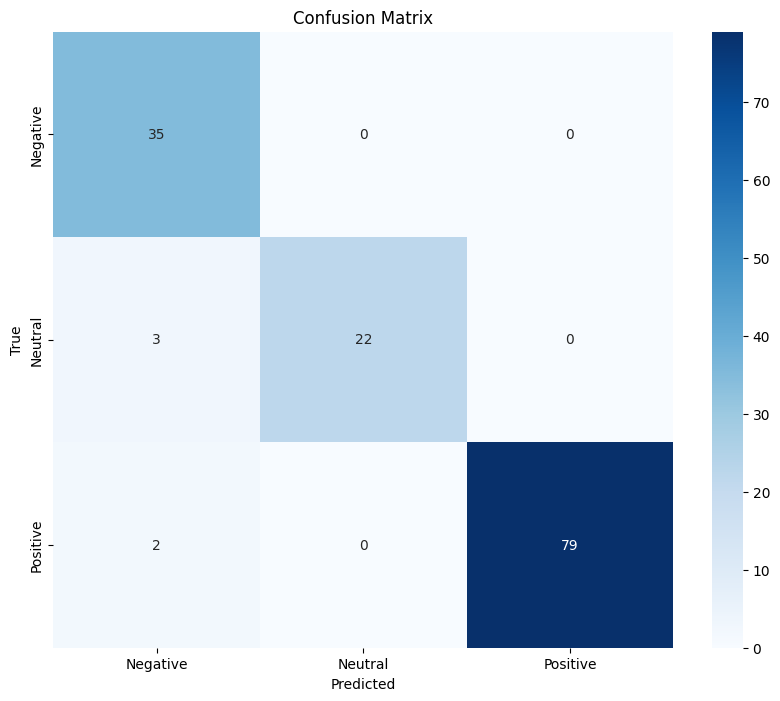

In [2093]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()